Computer Vision
# **Individual Assignment**
### **Image Classification: Distracted Driver Actions**
### **Model 5 - ResNet-50 (Batch 50 - RMSprop - α = 0.01)**

Professor: Hind Azegrouz

Assignment done by:
- João André Pinho

--------------------------

# **Assignment Description**

In this assignment you are given driver images, each taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). Your goal is to predict what the driver is doing in each picture.

The 10 classes to predict are:
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

### **Task:**

Experiment with different Deep neural networks to build an image classifier for the task in hand

- **Build neural network from scratch;**

- **-> Build neural network using transfer learning;**

- **-> Experiment with different hyperparameters and report findings.**

--------------------------

# **Resolution**

### **• Libraries and Module Imports:**

Importing the necessary libraries and modules to manipulate and interact with the dataset.

In [28]:
# Importing the necessary libraries and modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf
import os
from random import randint
import random
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.models import load_model
from keras.models import save_model
from keras import backend as K
from keras.applications import ResNet50
from keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
import seaborn as sns

### **• Loading the Data:**

Loading the Drivers list CSV and setting the paths for the Training and Testing images.

In [2]:
# Loading the Driver Images list CSV.
drivers_images_list_df = pd.read_csv('Data/driver_imgs_list.csv')

In [3]:
# Checking the information and schema of the dataframe.
drivers_images_list_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
# Defining the Training images folder path in order to feed the different models.
training_folder_path = 'Data/imgs/train'

In [5]:
# Defining the Training images folder path in order to feed the different models.
testing_folder_path = 'Data/imgs/test'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **PART I: Data Exploration**

### **• Central Question:**

#### *"Can a Computer Vision Model be built in order to be able to detect and properly classify different drivers behaviors while driving?"*

### **• Raw Data Amount:**

Given the amount of data that is necessary in order to feed an effective and accurate Computer Vision model, it is mandatory to check how many data points are available both for training and testing. 

In [6]:
# Defining a function to count the number of images that are available in the provided directories.
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

In [7]:
# Identifying the number of images in the training set.
train_file_count = count_files(training_folder_path)
print(f" The Training set contains {train_file_count} images.")

 The Training set contains 22424 images.


In [8]:
# Identifying the number of images in the testing set.
test_file_count = count_files(testing_folder_path)
print(f" The Testing set contains {test_file_count} images.")

 The Testing set contains 79726 images.


**Resulting Hypothesis:** Given the considerable size of both the training and testing image sets and the fairly easy identifiable visual patterns in the actions that the drivers are performing, data augmentation for the purpose of increasing the data that is fed to the model may not be necessary. 

For other purposes, like improving generalization - to expose the model to different picture variations (i.e., scalings, different lighting conditions ...), this process might still be advisable in some batches in order to make the model more robust and performing in different real-world scenarios.

This model iteration will be also be tested without it.

### **• Raw Data Dimentions:**

Given the importance of standardizing image dimensions in some Computer Vision models, for these to be able to identify the right patterns and relationships between pixels, it is crucial to check if all training images follow the same dimensions.

In [9]:
# Constructing a function to check if the images dimensions is constant and what dimensions do they present.
def check_image_dimensions(root_dir):
    dimensions = None
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            for file_name in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file_name)
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image = Image.open(file_path)
                    img_width, img_height = image.size
                    if dimensions is None:
                        dimensions = (img_width, img_height)
                    elif dimensions != (img_width, img_height):
                        print(f"Inconsistent dimensions found in {file_path}. Expected: {dimensions}, Actual: ({img_width}, {img_height})")
    if dimensions is not None:
         print("All images have consistent dimensions:", dimensions)

In [10]:
# Checking the image dimensions on the Training set.
check_image_dimensions(training_folder_path)

All images have consistent dimensions: (640, 480)


### **• Raw Data Visualization:**

In order to better know which activities the built model will need to identify, it is helpful to visualize at least a picture of each class to know what patterns to expect.

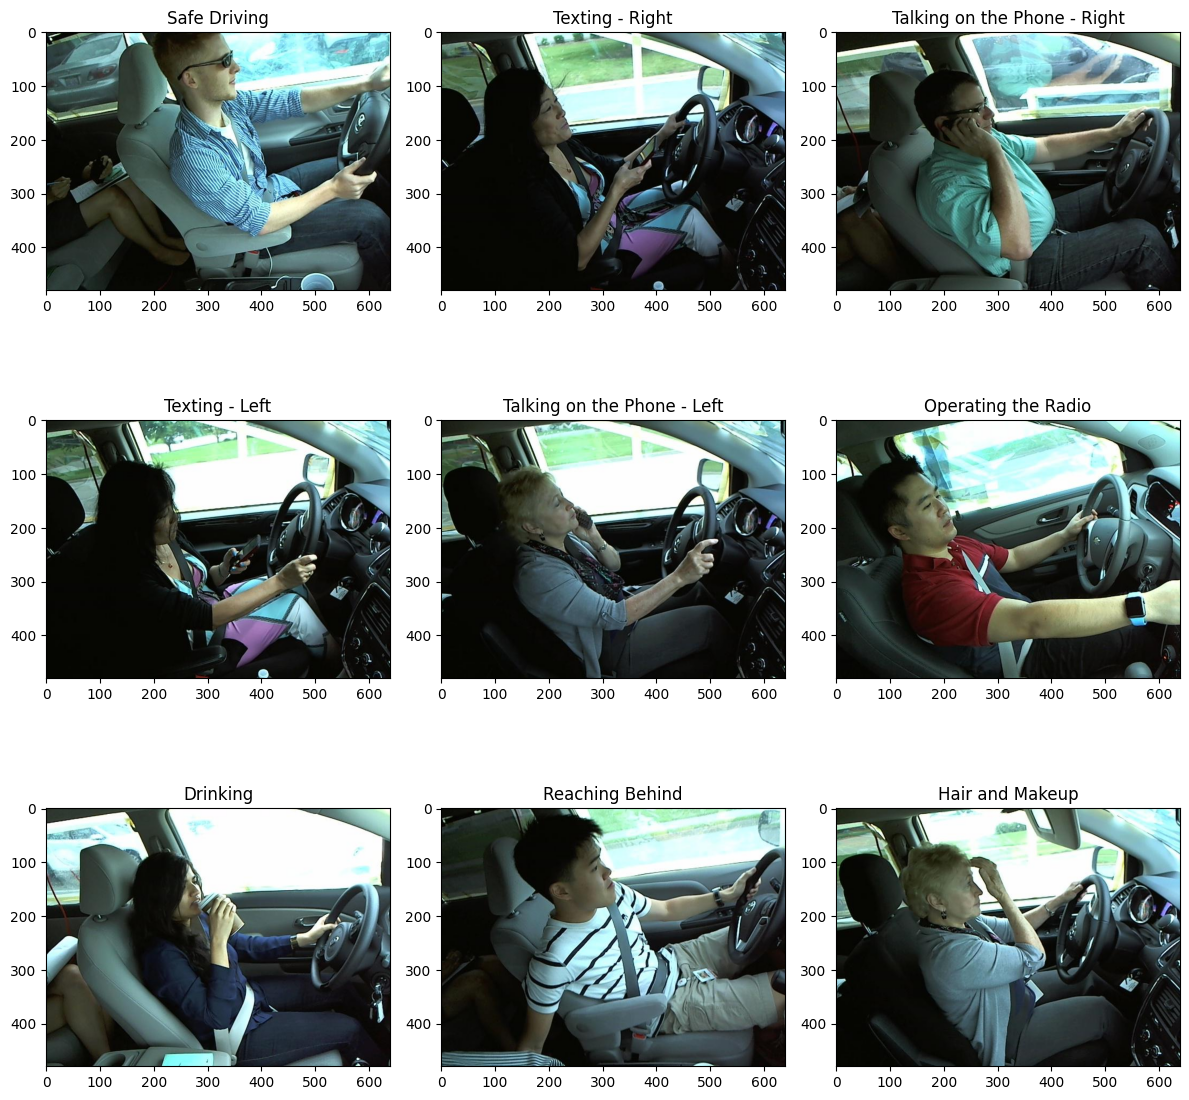

In [11]:
# Identifying the image directory where the images are stored.
image_dir = training_folder_path

# Mapping of activity titles for each type.
activity_classes = {
    "c0": "Safe Driving",
    "c1": "Texting - Right",
    "c2": "Talking on the Phone - Right",
    "c3": "Texting - Left",
    "c4": "Talking on the Phone - Left",
    "c5": "Operating the Radio",
    "c6": "Drinking",
    "c7": "Reaching Behind",
    "c8": "Hair and Makeup",
    "c9": "Talking to Passenger"
}

# Initializing a subplot to display the images.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.ravel()

# Looping through each activity type and displaying one image with the corresponding title.
for i, activity_type in enumerate(sorted(activity_classes.keys())[:9]):
    
    # Getting the path of the first image for the activity type.
    activity_dir = os.path.join(image_dir, activity_type)
    image_name = os.listdir(activity_dir)[0]
    image_path = os.path.join(activity_dir, image_name)
    
    # Loading and displaying the images.
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(activity_classes[activity_type])
    axes[i].axis('on')

# Adjusting image spacing and displaying the plots.
plt.tight_layout()
plt.show()

### **• Class and Subject Data Distribution:**

It is important to confirm that the number of images per distractor activity class and driver is balanced so that the models don't become biased towards a majority class or individual image set. This way, there will be enough generaliation and robustness and data scarcity will be avoided.

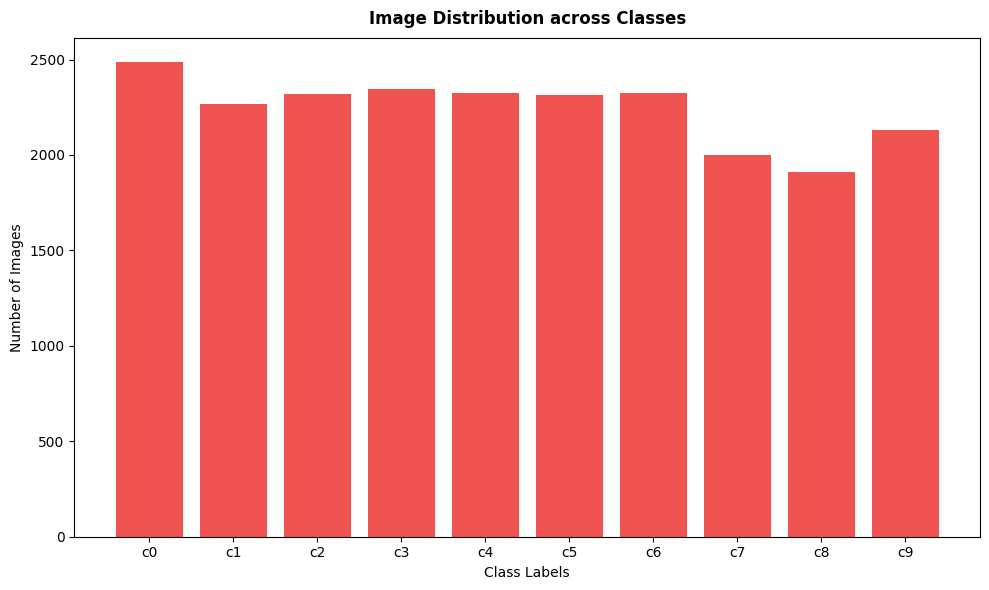

In [12]:
# Initializing empty lists to store class labels and corresponding image counts.
class_labels = []
image_counts = []

# Iterating through each subdirectory in the train directory and appending the different counts.
for subdir in os.listdir(image_dir):
    subdir_path = os.path.join(image_dir, subdir)
    if os.path.isdir(subdir_path):
        class_labels.append(subdir)
        image_counts.append(len(os.listdir(subdir_path)))

# Plotting a vertical bar chart with the class data distribution.
plt.figure(figsize=(10, 6))
plt.bar(class_labels, image_counts, color = '#EF5350')
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Image Distribution across Classes", fontweight='bold', pad=10)
plt.tight_layout()
plt.show()

**Insight:** Since the training dataset is fairly balanced, there appears to be no need for downsampling data. 

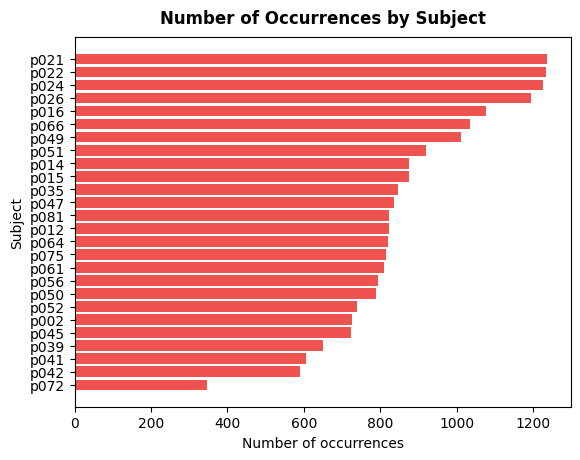

In [13]:
# Counting the number of occurrences of each subject.
subject_counts = drivers_images_list_df['subject'].value_counts()

# Sorting the subjects based on their counts in descending order.
subject_counts = subject_counts.sort_values(ascending=True)

# Creating a horizontal bar chart.
plt.barh(subject_counts.index, subject_counts.values, color = '#EF5350')

# Setting the chart title.
plt.title('Number of Occurrences by Subject',fontweight='bold', pad=10)

# Setting labels for the x and y axes.
plt.xlabel('Number of occurrences')
plt.ylabel('Subject')

# Displaying the chart.
plt.show()

**Insight:** As observable, some individuals have less images to be trained on. Due to this fact, it is expected that the model will learn more from the behaviour of the subjects with more available data, leading to a higher number of right predictions on their images.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Model 5 - ResNet-50 (Batch 50 - RMSprop - α = 0.01):**

By leveraging transfer learning - a technique where an existing trained model is re-used for a given task (with some slight adaptations on the final layers) because of the performance resulting from the amount of data that was trained on, using ResNet-50.

### **PART II: Data Preprocessing**

### **• Image Normalization:**

This step is commonly performed on images before feeding them into a deep learning model. By dividing each pixel value in an image by a scaling factor (in this case 255) pixel values will be brought to a standardized range between 0 and 1. In terms of the benefits of this step, 2 can be highlighted:

- **Gradient Convergence:** In order to properly update models' weights, algorithms usually work better when the input features (pixels) are within the same numerical range, hence normalization helps to increase the efficiency and stability of convergence. 

- **Model Generalization:** Normalizing pixel values usually improves models' generalization performance, as these become less sensitive to input intensity levels (i.e., dealing better with illumination, contrasts... across images).

In [14]:
# Normalizing pixel values by dviding feature values by 255.
# Holding back 30% of the images for validation.
print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

Getting Data...


### **• Hyperparameter Setting 1:**

As ResNet-50 was already trained with different size images, in this case 224 x 244 x 3 channels (RGB), so there is a need to transform the input images' dimensions into this format.

In [15]:
# Defining a batch size.
batch_size = 50

# Defining the image dimensions.
img_size = (244,244)

### **• Set Training and Validation Data:**

The validation split is a common practice in machine learning to assess the model's performance on unseen data and prevent overfitting. By holding back a portion of the images for validation, the model can be evaluated on data it hasn't seen during training, providing a more reliable estimate of its performance on new, unseen samples. During training, the model's performance is monitored using the training set, while the validation set helps in identifying potential issues like overfitting or underfitting. It allows for adjusting model hyperparameters, such as learning rate or regularization, based on the validation performance to optimize the model's performance on unseen data.

In this case, 30% of the images will be set aside for validation, while the remaining 70% will be used for training the model.

In [16]:
# Getting the classes of the images.
classes = sorted(os.listdir(training_folder_path))
print(classes)

# Setting the Training data.
print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Setting the Validation data.
print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Preparing training dataset...
Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


### **PART III: Model Definition**

### **• Model Elements:**

In order to define a Convolutional Neural Network (CNN) model, there are a certain elements that need to be involved:

1. **Model Type**: Sequential is a straightforward model type that allows to define a linear stack of sequential layers that build a CNN.

2. **Optimizer:** Element responsible for updating the model's parameters during training in order to minimize loss. These ones determine how models' adjust their weights based on computed gradients. Each optimizer has its own algorithm and hyperparameters.

3. **Learning Rate:** This one is the hyperparameter that controls the step size taken during each model's update of its parameters. It determines the speed at which the model learns and how quickly it converges. It is always important to define a proper learning rate value. If the learning rate is too high, the model might fail to converge into the optimal solution, if its too slow, the model might take an unecessary amount of time to find an optimal or suboptimal solution.

4. **Convolutional Layers:** These are the core blocks of CNNs. By applying kernels or filters to the input data, the network will learn spacial hierarchies of features and local patterns between pixels allowing it to be able to better classify images. These layers usually perform actions like edge, texture or shape recognition.

5. **(Optional) Padding:** This technique consists of adding extra pixels or values around the borders of an image or feature map. Padding can be useful for both maintaining the spatial information at the borders of the input and also to retain the original size of the input or feature map, allowing the subsequent layers to process information from the entire input space. There are two types of padding: "valid" and "same." In the "valid" padding scheme, no padding is added, and the output size is reduced due to the filter/kernel sliding across the input. In contrast, the "same" padding scheme adds padding equally to all sides of the input, ensuring that the output size matches the input size.

6. **(Optional) Max Pooling:** Downsampling technique that is able to reduce the spatial dimensions of the input by selecting the maximum value value within a local region of the input feature map. This step, although optional, helps reduce computational complexity by extracting only the most important features, enhancing models' translation invariance (ability of a model to recognize and understand objects or patterns regardless of their position or location within an image).

7. **(Optional) Dropout:** Regularization technique that is used to prevent overfitting and improve models' generalization performance. By randomly droping out a fraction of the input units (neurons) to zero at each update, this element forces netwroks to learn more robust and generalizable features by reducing the reliance on specific neurons and promoting distribute learning across a wider range of units.

8. **Flatten:** Since the last layers of the network expect a one-dimensional input, the flatten step is necessary in order to reshape a matrix or tensor into a vector format.

9. **Dense Layers:** Also known as fully connected layers, are layers where each neuron is connected to every other neuron in the previous and next layers. These layers can help to capture global relationships, and make the final prediction based on the learned features.

10. **Loss Function:** For multi-class classification tasks, categorical cross entropy is a popular loss function that measures the dissimilarity between the predicted class probabilities and the true class labels. The end goal of every model its to minimize this loss function during training, in order to generate more accurate class predictions.

### **• Model 5 - ResNet50 (Batch 50 - RMSprop - α = 0.01) Configuration:**

For a first attempt at building a performing model for these distracted driver actions image classification, the following custom sequence of layers and transformations will be made to the input data from scratch:

<img src="Images/resnet50_architecture.png" alt="ResNet50" width="800"/>

1. **Convolutional Layer** (Filters - 64; Kernel Size - 7x7, Stride - 2x2, Padding - Same, Activation - ReLU)

2. **Max Pooling Layer** (Pool Size - 3x3, Stride - 2x2, Padding - Same)

3. **Residual Block 1**:

    - **Convolutional Layer** (Filters - 64; Kernel Size - 1x1, Stride - 1x1, Padding - Valid, Activation - ReLU)

    - **Convolutional Layer** (Filters - 64; Kernel Size - 3x3, Stride - 1x1, Padding - Same, Activation - ReLU)

    - **Convolutional Layer** (Filters - 256; Kernel Size - 1x1, Stride - 1x1, Padding - Valid)

    - **Shortcut Connection**: Identity mapping or 1x1 convolutional layer to match the dimensions (if needed)

    - **Addition of the shortcut and the main path**

    - **Activation** - ReLU


4. **Residual Block 2**:

    - **Convolutional Layer** (Filters - 128; Kernel Size - 1x1, Stride - 2x2, Padding - Valid, Activation - ReLU)

    - **Convolutional Layer** (Filters - 128; Kernel Size - 3x3, Stride - 1x1, Padding - Same, Activation - ReLU)

    - **Convolutional Layer** (Filters - 512; Kernel Size - 1x1, Stride - 1x1, Padding - Valid)

    - **Shortcut Connection:** 1x1 convolutional layer to match the dimensions

    - **Addition of the shortcut and the main path**

    - **Activation** - ReLU


5. **Residual Block 3**:

    - **Convolutional Layer** (Filters - 256; Kernel Size - 1x1, Stride - 2x2, Padding - Valid, Activation - ReLU)

    - **Convolutional Layer** (Filters - 256; Kernel Size - 3x3, Stride - 1x1, Padding - Same, Activation - ReLU)

    - **Convolutional Layer** (Filters - 1024; Kernel Size - 1x1, Stride - 1x1, Padding - Valid)

    - **Shortcut Connection:** 1x1 convolutional layer to match the dimensions

    - **Addition of the shortcut and the main path**

    - **Activation** - ReLU


6. **Residual Block 4:**

    - **Convolutional Layer** (Filters - 512; Kernel Size - 1x1, Stride - 2x2, Padding - Valid, Activation - ReLU)

    - **Convolutional Layer** (Filters - 512; Kernel Size - 3x3, Stride - 1x1, Padding - Same, Activation - ReLU)

    - **Convolutional Layer** (Filters - 2048; Kernel Size - 1x1, Stride - 1x1, Padding - Valid)

    - **Shortcut Connection:** 1x1 convolutional layer to match the dimensions

    - **Addition of the shortcut and the main path**

    - **Activation** - ReLU


7. **Average Pooling Layer** (Pool Size - 7x7, Stride - 1x1)

8. **Flatten Layer**

9. **Dense Layer** (Number of Units - # Classes, Activation - Softmax)

**(+) Advantages of this Model:**
- **Deeper Architecture:** ResNet-50 is a deeper architecture compared to previous models like VGG16. It allows for better feature representation by capturing more abstract and intricate patterns from images.
- **Better Gradient Flow:** The inclusion of residual connections in ResNet-50 allow the gradient to flow directly through the identity mappings, enabling better information propagation during training.
- **Transfer Learning Capabilities:** ResNet-50 has been pre-trained on a large-scale ImageNet dataset, enabling it to converge faster with a good accuracy due to previously learned weights.

**(-) Disadvantages of this Model:**
- **High Computational Requirements:** Given its depth and high number of parameters, ResNet-50 is computationally expensive to train and deploy. Hence, only a limited amount of epochs will be performed.
- **Prone to Overfitting:** ResNet-50 deep architecture makes it especially prone to overfitting, especially with small datasets. Regularization techniques such as dropout and weight decay can offen mitigate this issue.
- **Difficulty in interpretability:** The deeper and more complex architecture of ResNet-50 can make it challenging to interpret the learned representations.

In terms of the **optimizer**, the one chosen will be **RMSprop** - an adaptive learning rate optimization algorithm specifically designed for training deep neural networks

In terms of the **loss function**, the one chosen will be **Categorical Cross Entropy**.

**- Loading ResNet-50 model:**

In [17]:
# Loading the base model, not including its final connected layer, and set the input shape to match the one from the training images.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

**- Freezing the already trained layers and adding add custom layers before the output layer:**

In [18]:
# Freezing the already-trained layers in the base model 5.
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Creating the final layers for the classification of the input images.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
prediction_layer = Dense(len(classes), activation='softmax')(x) 
model_5 = Model(inputs=base_model.input, outputs=prediction_layer)

In [20]:
# Defining the optimizer.
opt_5 = optimizers.RMSprop(learning_rate=0.01)

In [21]:
# Compiling the model for categorical multi-class classification.
model_5.compile(loss='categorical_crossentropy',
              optimizer=opt_5,
              metrics=['accuracy'])

In [22]:
# Checking the model 5 summary.
model_5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 122, 122, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 61, 61, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 61, 61, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 61, 61, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 61, 61, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 31, 31, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 31, 31, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 31, 31, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 31, 31, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

### **PART IV: Training Stage**

### **• Train Model 5 - ResNet-50 (Batch 50 - RMSprop - α = 0.01):**

With the layers of the ResNet-50  (Batch 50 - RMSprop - α = 0.01) defined, the model is ready to be trained using the training image data. In this training process, 2 iterations (epochs) will be used to train the model in 50-image batches, holding back 30% of the data for validation. After each epoch, the loss function will measure the error (loss) in the model and adjust its weights (which were randomly generated for the first iteration) to try to improve accuracy.

In [23]:
# Setting the number of epochs.
num_epochs = 2

# Training the model.
history = model_5.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/2
314/314 [==============================] - 1220s 4s/step - loss: 1.5000 - accuracy: 0.5351 - val_loss: 11.1930 - val_accuracy: 0.2076
Epoch 2/2
314/314 [==============================] - 1224s 4s/step - loss: 0.7810 - accuracy: 0.7510 - val_loss: 7.2871 - val_accuracy: 0.2124


### **• Visualize Loss History for Model 5 - ResNet-50 (Batch 50 - RMSprop - α = 0.01):**

Once trained, it is necessary to verify the reduction history of the loss function as well as if the model is over-fitted - learning to perform extremely well on the training data, but failing to generalize and perform well on unseen data. This overfitting can be spotted by a continuos drop in training loss after validation loss has levelled out or started to increase. 

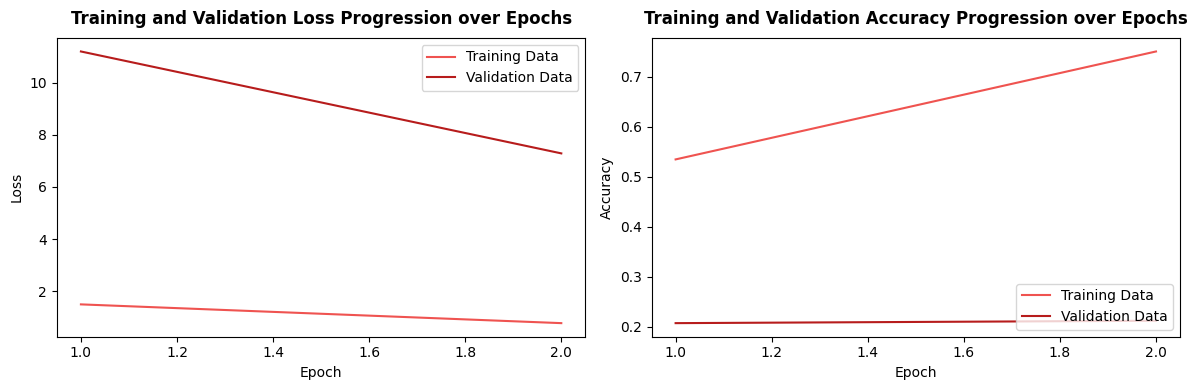

In [24]:
# Plotting the training and validation loss progression over epochs.
%matplotlib inline

# Plotting the training and validation loss progression over epochs.
plt.figure(figsize=(12, 4))

# Plotting the loss
plt.subplot(1, 2, 1)
epoch_nums = range(1, num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss, color='#EF5350')
plt.plot(epoch_nums, validation_loss, color='#b71c1c')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss Progression over Epochs", fontweight='bold', pad=10)
plt.legend(['Training Data', 'Validation Data'], loc='upper right')

# Plotting the accuracy
plt.subplot(1, 2, 2)
training_acc = history.history["accuracy"]
validation_acc = history.history["val_accuracy"]
plt.plot(epoch_nums, training_acc, color='#EF5350')
plt.plot(epoch_nums, validation_acc, color='#b71c1c')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy Progression over Epochs", fontweight='bold', pad=10)
plt.legend(['Training Data', 'Validation Data'], loc='lower right')

plt.tight_layout()
plt.show()

**Insights:** As it can be concluded, ResNet50 might need a lot more epochs in order to reach a better validation set accuracy. Given that other models reach it faster and more accurately, this model may be ignored for the present exercise.

### **PART V: Final Conclusion**

Delivering a below standard treshold performance for these sort of exercises, this model proved to not be worth continued to explored. Since both the accuracy and speed of the training stage were below ideal, this one should be discarded.

**Note:** Possible other combinations might have resulted in a better performing model using ResNet50.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------